In [8]:
# analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")

# missings (imputer)
# from sklearn.impute import SimpleImputer, KNNImputer

# interacciones
from sklearn.preprocessing import PolynomialFeatures

# transformaciones
from sklearn.compose import ColumnTransformer
# - variab numéricas
from sklearn.preprocessing import RobustScaler # MinMaxScaler, StandardScaler, Normalizer, Binarizer 
# from sklearn.preprocessing import PowerTransformer, BoxCox
# - variab categ
from sklearn.preprocessing import OneHotEncoder # LabelEncoder, OrdinalEncoder

# feature selection
from sklearn.feature_selection import f_classif # chi2
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import RFE, RFECV
# from sklearn.decomposition import PCA

# algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # red neuronal

# bagging
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

# boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# import xgboost as xgb

# model selection
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.pipeline import Pipeline #make_pipeline
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, ParameterGrid

# Técnicas de evaluación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

In [9]:
# semilla de aleatorización

seed = 99

In [10]:
data = pd.read_csv('Datasets/datos_procesados.csv')

print(f'Número de filas: {data.shape[0]}, Númerode columnas:{data.shape[1]}')

Número de filas: 4687, Númerode columnas:24


In [11]:
# Separar en train y test
X_train = data[data['Dataset'] == 'train'].drop(['Dataset'], axis=1)
X_test = data[data['Dataset'] == 'test'].drop(['Dataset'], axis=1)

# variable objetivo (.pop elimina la col de X, que también es un paso necesario)
y_train = X_train.pop('Hazardous')
y_test = X_test.pop('Hazardous')

In [12]:
# SMOTE (remuestro de datos de entrenamiento desbalanceados)

# Probaremos a obtener el mejor modelo tanto con los train_data desbalanceados como balanceados con smote

categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')

smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
             random_state=seed)

X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

## 2.a Bagging

* **Bagging** es crear varios modelos, todos del mismo algoritmo, entrenados con distintas muestras (bootstrapping), y sus resultados se promedian.

* **Random Forest** es un caso de bagging con árboles, donde cada árbol se construye utilizando una muestra bootstrapeada y una selección aleatoria de variabs en cada división del árbol.

In [13]:
# 1ª etapa (with all features)

import time
start_time = time.time()

# Algoritmo a probar
model = BaggingClassifier(estimator=LogisticRegression(
                                        max_iter=100,
                                        penalty='l1',
                                        C= 0.1,
                                        solver='liblinear',
                                        class_weight='balanced',
                                        random_state=seed), random_state=seed)

# Definir variabs numéricas y categóricas
scaler_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categ_features = [feature for feature in X_train.columns if feature not in scaler_features]

# Column transformer
col_transformer = ColumnTransformer(
    [
    ('encoder', OneHotEncoder(drop=["3-9"]), ['Orbit Uncertainity (categ)']), # @@ necesario??
    ('scaler', RobustScaler(), scaler_features)
    ], remainder='passthrough')

##### no hace falta ejecutar esta parte, no hay paráms que buscar, podemos hacer solo la 2ª etapa

# # Definir instancia SMOTENC
# categ_index = X_train.columns.get_loc('Orbit Uncertainity (categ)')
# smote_nc = SMOTENC(categorical_features=[categ_index], # hay que indicarle cuál es la variab categ en el dataset que se va a transformar
#              random_state=seed)

# # Pipeline 1
# pipe = Pipeline([
# #         ('smote_nc', smote_nc), # quitarlo si class_weight='balanced'
#         ('column_transform', col_transformer),
#         ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
#         ('algorithm', model)        
# ])

# # Tuneado del modelo (malla de paráms)
#     # Podríamos buscar los mejores paráms teniendo en cuenta también los paráms de cada árbol.
#     # Pero la ejecución tarda mucho, y en el apartado 2 ya vimos cuál era el mejor árbol para
#     # nuestro dataset, así que nos basamos en ese árbol (lo definimos arriba)
# parametros = {
#     "algorithm__n_estimators": [20,30,40], # número de regr logists en el Bagging
#     "algorithm__max_samples": [0.5, 0.75, 1] # si 1, hace reemplazamiento (para que sea bootstrapping)
# #     "algorithm__max_features": [1] # dejamos que use todas, no queremos ahora RandomForest
# }

# Repeated cross_val (stratified)
# cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_technique = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# # combinamos todo
# gsearch = GridSearchCV(estimator=pipe, cv=cv_technique, param_grid=parametros, scoring='f1')

# # buscamos el mejor modelo
# # opción a) sin resample y con class_weight='balanced':
# grid_model = gsearch.fit(X_train, y_train)

# # opción b) con resample (SMOTE)
# # grid_model = gsearch.fit(X_train_resampled, y_train_resampled)

# print("Best CV score:", grid_model.best_score_)

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")


Tiempo de ejecución: 0.0010023117065429688 segundos


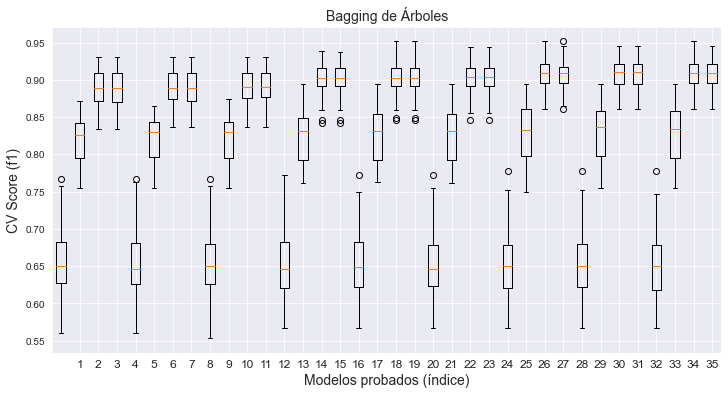


Tiempo de ejecución: 162.63491582870483 segundos


In [14]:
# 2ª etapa: boxplot para elegir el resto de paráms

# no podemos poner muchos paráms, o no veremos nada en los boxplots
# por eso aquí hay traer ya algunos paráms elegido


import time
start_time = time.time()

pipe_fs = Pipeline([
        ('column_transform', col_transformer),
        ('polynomial', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # añadir interacciones
        ('feature_selection', SelectKBest(score_func=f_classif)), # k = número de variabs a seleccionar
#         ('algorithm', grid_model.best_estimator_.named_steps['algorithm']) 
        ('algorithm', model) 
]) # importante: meter el mejor algorithm obtenido antes

parametros_fs = {
    "feature_selection__k": [3,4,5,6],
    "algorithm__n_estimators": [10,20,30], # número de árboles en el Bagging
    "algorithm__max_samples": [0.5, 0.75, 1.0] # OJO: si pones 1 (int) coge solo 1 muestra. 1.0 es el 100% de las muestras
}

# Cambiar el formato de la malla de parámetros para poder usarlos en el bucle for
grid_params = list(ParameterGrid(parametros_fs)) # lista de diccionarios

cv_scores = []
for params in grid_params:
    # Configurar los parámetros del pipeline
    pipe_fs.set_params(**params)
    
    # Calcular los scores
    scores = cross_val_score(pipe_fs,
                             X_train, y_train, # X_train_resampled, y_train_resampled
                             cv=cv_technique, scoring='f1')
    cv_scores.append(scores)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(cv_scores)
plt.title('Bagging de Árboles', fontsize=14)
plt.xlabel('Modelos probados (índice)', fontsize=14)
plt.ylabel('CV Score (f1)', fontsize=14)
plt.xticks(range(2, len(cv_scores)+1), fontsize=12) # no consigo poner el xtick = 0
plt.show()

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

In [15]:
# Comparar mejores
print(grid_params[14])
print(grid_params[15])
print(grid_params[18])
print(grid_params[19])
print(grid_params[22])
print(grid_params[23])
print(grid_params[26])
print(grid_params[27])

## A iguales resultados, escogemos menor n_estimator y el menor max_samples

{'algorithm__max_samples': 0.75, 'algorithm__n_estimators': 10, 'feature_selection__k': 5}

{'algorithm__max_samples': 0.75, 'algorithm__n_estimators': 10, 'feature_selection__k': 6}

{'algorithm__max_samples': 0.75, 'algorithm__n_estimators': 20, 'feature_selection__k': 5}

{'algorithm__max_samples': 0.75, 'algorithm__n_estimators': 20, 'feature_selection__k': 6}

{'algorithm__max_samples': 0.75, 'algorithm__n_estimators': 30, 'feature_selection__k': 5}

{'algorithm__max_samples': 0.75, 'algorithm__n_estimators': 30, 'feature_selection__k': 6}

{'algorithm__max_samples': 1.0, 'algorithm__n_estimators': 10, 'feature_selection__k': 5}

{'algorithm__max_samples': 1.0, 'algorithm__n_estimators': 10, 'feature_selection__k': 6}


In [34]:
# El mejor modelo es:
modelo_optimo = 26 # indicar nº óptimo

# Configura el pipeline con los parámetros deseados
selected_params = grid_params[modelo_optimo]
pipe_fs.set_params(**selected_params)

# Ajusta el modelo
selected_model = pipe_fs.fit(X_train, y_train)
selected_model

Pipeline(steps=[('column_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop=['3-9']),
                                                  ['Orbit Uncertainity '
                                                   '(categ)']),
                                                 ('scaler', RobustScaler(),
                                                  ['Est Dia in M(max)',
                                                   'Relative Velocity km per '
                                                   'sec',
                                                   'Miss Dist.(Astronomical)',
                                                   'Minimum Orbit Intersection',
                                                   'Eccentricity',
                                                   'Semi Major Axis',
                                                   'Inclination',
                                                   'Asc Node Longitude...
                                                   'Distance_squared',
                                                   'Mean Anomaly_raiz2',
                                                   'Mean Motion_cuarta',
                                                   'Perihelion '
                                                   'Arg_squared'])])),
                ('polynomial',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('feature_selection', SelectKBest(k=5)),
                ('algorithm',
                 BaggingClassifier(estimator=LogisticRegression(C=0.1,
                                                                class_weight='balanced',
                                                                penalty='l1',
                                                                random_state=99,
                                                                solver='liblinear'),
                                   random_state=99))])

In [35]:
selected_model.named_steps['algorithm'].get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__C': 0.1,
 'estimator__class_weight': 'balanced',
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l1',
 'estimator__random_state': 99,
 'estimator__solver': 'liblinear',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                    random_state=99, solver='liblinear'),
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 99,
 'verbose': 0,
 'warm_start': False}

In [36]:
# Variables seleccionadas:

ct_names = selected_model.named_steps['column_transform'].get_feature_names_out()
poly_names = selected_model.named_steps['polynomial'].get_feature_names_out(input_features=ct_names)
select_names = selected_model.named_steps['feature_selection'].get_feature_names_out(input_features=poly_names)

print(f"Las {len(select_names)} variabs seleccionadas son:")
[i for i in select_names]

Las 5 variabs seleccionadas son:


['scaler__Minimum Orbit Intersection',
 'scaler__Est Dia in M(max)_raiz2',
 'encoder__Orbit Uncertainity (categ)_0 scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max)_raiz2 scaler__Minimum Orbit Intersection_log']

El valor de f1 score es: 
 0.9
Otros estadísticos del test: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       787
           1       0.83      0.99      0.90       151

    accuracy                           0.96       938
   macro avg       0.91      0.97      0.94       938
weighted avg       0.97      0.96      0.97       938



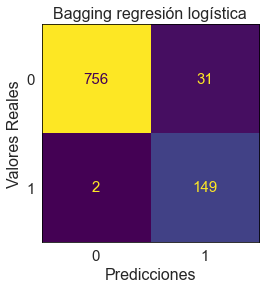

In [37]:
# Score y Confusion Matrix

# Evalúa el mejor modelo en tus datos de prueba
y_pred = selected_model.predict(X_test)

# Calcular la precisión de las predicciones en el conjunto de prueba
print(f"El valor de f1 score es: \n {f1_score(y_test, y_pred).round(3)}")
print(f"Otros estadísticos del test: \n {classification_report(y_test, y_pred)}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='viridis', values_format='d', colorbar=False)
ax.grid(False) # Deshabilitar el grid de fondo

# plt.title('Matriz de confusión', fontsize=18) # Cambiar tamaño del título
ax.spines[['bottom','top','left','right']].set_color('black')
plt.title('Bagging regresión logística', fontsize=16)
plt.xlabel('Predicciones', fontsize=16)
plt.ylabel('Valores Reales', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for text in ax.texts:
    text.set_fontsize(15)
plt.show()

In [39]:
import pickle

# Guarda los datos de puntuaciones
with open('cv_scores_model10.pkl', 'wb') as f:
    pickle.dump(cv_scores[modelo_optimo], f)